In [6]:
import mysql_connection
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
import numpy as np

def fetch_data(teams):
    connection = mysql_connection.get_mysql_connection()
    if connection:
        if teams == 'All':
            sql_query = """
            SELECT team_1, team_2, winner, margin, ground, match_date, match_id, team_1_score, team_1_wicket, team_1_over, team_2_score, team_2_wicket, team_2_over, team_1_total_over, team_2_total_over, first_bat_team, second_bat_team
            FROM cricket_info.matches;
            """
            cursor = connection.cursor()
            cursor.execute(sql_query)
        else:
            sql_query = """
            SELECT team_1, team_2, winner, margin, ground, match_date, match_id, 
                   team_1_score, team_1_wicket, team_1_over, team_2_score, team_2_wicket, 
                   team_2_over, team_1_total_over, team_2_total_over, first_bat_team, 
                   second_bat_team
            FROM cricket_info.matches
            WHERE team_1 IN ({}) OR team_2 IN ({});
            """.format(','.join(['%s']*len(teams)), ','.join(['%s']*len(teams)))

            cursor = connection.cursor()
            cursor.execute(sql_query, teams*2)
           
        rows = cursor.fetchall()
        df = pd.DataFrame(rows, columns=['team_1', 'team_2', 'winner', 'margin', 'ground', 'match_date', 'match_id', 'team_1_score', 'team_1_wicket', 'team_1_over', 'team_2_score', 'team_2_wicket', 'team_2_over', 'team_1_total_over', 'team_2_total_over', 'first_bat_team', 'second_bat_team'])
        cursor.close()
        connection.close()
        return df
    else:
        print("Connection to the database failed.")
        return None

# Function to convert string representation of overs to balls 
def overs_to_balls(overs_str):
    # Split overs into integer and fractional parts
    parts = str(overs_str).split('.')
    
    # If only integer part is present
    if len(parts) == 1:
        overs_int = int(parts[0])
        overs_frac = 0
    # If both integer and fractional parts are present
    elif len(parts) == 2:
        overs_int = int(parts[0])
        overs_frac = int(parts[1])
    else:
        raise ValueError("Invalid overs string format")

    # Convert overs to balls and add fractional part
    balls = overs_int * 6 + overs_frac
    
    return balls


def transform_data(df):

    # Create new columns to store wickets and runs margins
    df['wickets_margin'] = 0
    df['runs_margin'] = 0
    
    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        margin = row['margin']
        if 'wickets' in margin:
            # Extract the number for wickets margin
            wickets_margin = int(margin.split()[0])
            df.at[index, 'wickets_margin'] = wickets_margin
            df.at[index, 'runs_margin'] = 0

        elif 'runs' in margin:
            # Extract the number for runs margin
            runs_margin = int(margin.split()[0])
            df.at[index, 'runs_margin'] = runs_margin
            df.at[index, 'wickets_margin'] = 0


        else:
            df.at[index, 'wickets_margin'] = 0
            df.at[index, 'runs_margin'] = 0

    df['date'] = pd.to_datetime(df['match_date'], format='%b %d, %Y', errors='coerce')
    df['team_1_score'] = pd.to_numeric(df['team_1_score'], errors='coerce')
    df['team_1_wicket'] = pd.to_numeric(df['team_1_wicket'], errors='coerce')
    df['team_1_over'] = df['team_1_over'].apply(overs_to_balls)
    df['team_2_score'] = pd.to_numeric(df['team_2_score'], errors='coerce')
    df['team_2_wicket'] = pd.to_numeric(df['team_2_wicket'], errors='coerce')
    df['team_2_over'] = df['team_2_over'].apply(overs_to_balls)
    df['team_1_total_over'] = df['team_1_total_over'].apply(overs_to_balls)
    df['team_2_total_over'] = df['team_2_total_over'].apply(overs_to_balls)

    df.drop(columns=['margin'], inplace=True)
    df.drop(columns=['match_id'], inplace=True)
    df.drop(columns=['match_date'], inplace=True)


    print(df)
    print(df.dtypes)

    return df



# team = ['New Zealand', 'Sri Lanka', 'Australia']
team = 'All'
df = fetch_data(team)
# print(df)
data_df = transform_data(df)
print("@@@@@@@@@@@")
print(data_df)

# Define the DataFrame data_df
# Assuming you already have this DataFrame defined

# Define the list of ICC T20 teams
icc_t20_teams = ["Afghanistan", "Australia", "Bangladesh", "England", "India", "New Zealand", "Pakistan", "South Africa", "Sri Lanka", "West Indies"]

# Filter the DataFrame based on the conditions
filtered_data1 = data_df[(data_df['second_bat_team'].isin(icc_t20_teams))]

print(filtered_data1)



# Apply condition 1: second_bat_team = team_1 and team_1_total_over == 120
condition_1 = (filtered_data1['second_bat_team'] == filtered_data1['team_1']) & (filtered_data1['team_1_total_over'] == 120)

# Apply condition 2: second_bat_team = team_2 and team_2_total_over == 120
condition_2 = (filtered_data1['second_bat_team'] == filtered_data1['team_2']) & (filtered_data1['team_2_total_over'] == 120)

# Apply both conditions using logical OR (|)
polt_data_df1 = filtered_data1[condition_1 | condition_2]

# Select only the required fields: score, wicket, over, date, second_bat_team
polt_data_df1 = polt_data_df1[['team_1_score', 'team_1_wicket', 'team_1_over', 'team_2_score', 'team_2_wicket', 'team_2_over', 'date', 'second_bat_team']]

# Rename columns based on conditions
polt_data_df1['score'] = polt_data_df1['team_1_score'].where(condition_1, polt_data_df1['team_2_score'])
polt_data_df1['wicket'] = polt_data_df1['team_1_wicket'].where(condition_1, polt_data_df1['team_2_wicket'])
polt_data_df1['over'] = polt_data_df1['team_1_over'].where(condition_1, polt_data_df1['team_2_over'])

# Drop unnecessary columns
polt_data_df1.drop(['team_1_score', 'team_1_wicket', 'team_1_over', 'team_2_score', 'team_2_wicket', 'team_2_over'], axis=1, inplace=True)

# Add new column "type" with value "icc_t20"
polt_data_df1['type'] = "icc_t20"

# Display the updated DataFrame
print(polt_data_df1)





# Define the list of ICC T20 teams
icc_t20_teams = ["Afghanistan", "Australia", "Bangladesh", "England", "India", "New Zealand", "Pakistan", "South Africa", "Sri Lanka", "West Indies"]

# Filter the DataFrame based on the conditions
filtered_data2 = data_df[~(data_df['second_bat_team'].isin(icc_t20_teams)) & (data_df['second_bat_team'] != 'NaN')]

print(filtered_data2)



# Apply condition 1: second_bat_team = team_1 and team_1_total_over == 120
condition_1 = (filtered_data2['second_bat_team'] == filtered_data2['team_1']) & (filtered_data2['team_1_total_over'] == 120)

# Apply condition 2: second_bat_team = team_2 and team_2_total_over == 120
condition_2 = (filtered_data2['second_bat_team'] == filtered_data2['team_2']) & (filtered_data2['team_2_total_over'] == 120)

# Apply both conditions using logical OR (|)
polt_data_df2 = filtered_data2[condition_1 | condition_2]

# Select only the required fields: score, wicket, over, date, second_bat_team
polt_data_df2 = polt_data_df2[['team_1_score', 'team_1_wicket', 'team_1_over', 'team_2_score', 'team_2_wicket', 'team_2_over', 'date', 'second_bat_team']]

# Rename columns based on conditions
polt_data_df2['score'] = polt_data_df2['team_1_score'].where(condition_1, polt_data_df2['team_2_score'])
polt_data_df2['wicket'] = polt_data_df2['team_1_wicket'].where(condition_1, polt_data_df2['team_2_wicket'])
polt_data_df2['over'] = polt_data_df2['team_1_over'].where(condition_1, polt_data_df2['team_2_over'])

# Drop unnecessary columns
polt_data_df2.drop(['team_1_score', 'team_1_wicket', 'team_1_over', 'team_2_score', 'team_2_wicket', 'team_2_over'], axis=1, inplace=True)

# Add new column "type" with value "icc_t20"
polt_data_df2['type'] = "others"

# Display the updated DataFrame
print(polt_data_df2)




Connected to MySQL database
            team_1       team_2       winner         ground  team_1_score  \
0     South Africa  New Zealand  New Zealand   Johannesburg           133   
1          England    Australia      England    Southampton           179   
2      New Zealand    Australia    Australia       Auckland           170   
3      New Zealand    Sri Lanka  New Zealand       Auckland           116   
4      New Zealand    Sri Lanka    Sri Lanka     Wellington           162   
...            ...          ...          ...            ...           ...   
2576     Sri Lanka     Zimbabwe    Sri Lanka  Colombo (RPS)           144   
2577   New Zealand     Pakistan  New Zealand       Hamilton           194   
2578   New Zealand     Pakistan  New Zealand       Auckland           226   
2579         India  Afghanistan        India         Mohali           159   
2580        U.A.E.  Afghanistan  Afghanistan        Sharjah           128   

      team_1_wicket  team_1_over  team_2_score 

In [7]:
combined_df = pd.concat([polt_data_df1, polt_data_df2], ignore_index=True)

print(combined_df)


           date second_bat_team  score  wicket  over     type
0    2005-10-21     New Zealand    134       5   108  icc_t20
1    2005-06-13       Australia     79      10    87  icc_t20
2    2005-02-17     New Zealand    170      10   120  icc_t20
3    2006-12-26     New Zealand    116       5   111  icc_t20
4    2006-12-01           India    127       4   119  icc_t20
...         ...             ...    ...     ...   ...      ...
2356 2024-01-29         Myanmar     75       9   117   others
2357 2024-01-28           China     37      10    92   others
2358 2024-01-27        Cambodia     74       3    55   others
2359 2024-01-16        Zimbabwe    178       6   119   others
2360 2024-01-02          U.A.E.    128       6   111   others

[2361 rows x 6 columns]


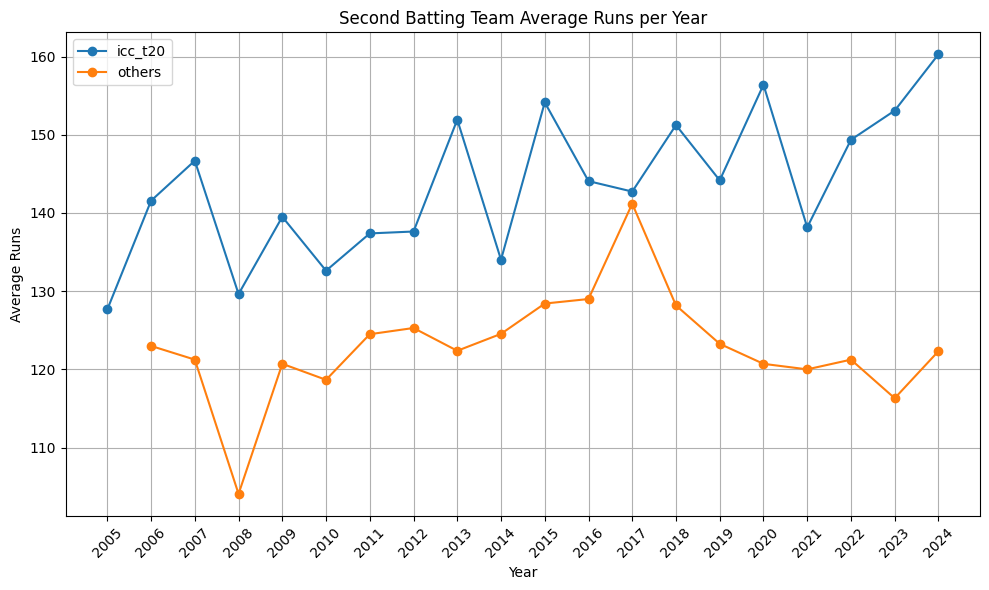

In [8]:
import matplotlib.pyplot as plt

# Filter data for icc_t20 and others
icc_t20_data = combined_df[combined_df['type'] == 'icc_t20']
others_data = combined_df[combined_df['type'] == 'others']

# Group data by year and calculate average runs
icc_t20_avg_runs = icc_t20_data.groupby(icc_t20_data['date'].dt.year)['score'].mean()
others_avg_runs = others_data.groupby(others_data['date'].dt.year)['score'].mean()

# Plotting
plt.figure(figsize=(10, 6))

# Line plot for icc_t20
plt.plot(icc_t20_avg_runs.index, icc_t20_avg_runs.values, marker='o', label='icc_t20')

# Line plot for others
plt.plot(others_avg_runs.index, others_avg_runs.values, marker='o', label='others')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Average Runs')
plt.title('Second Batting Team Average Runs per Year')
plt.legend()

# Customize x-axis to show years from 2005 to 2024
plt.xticks(range(2005, 2025, 1), rotation=45)

# Show grid
plt.grid(True)

# Save the plot
plt.tight_layout()
plt.savefig('Second Batting Team Average Runs per Year.png')
plt.show()

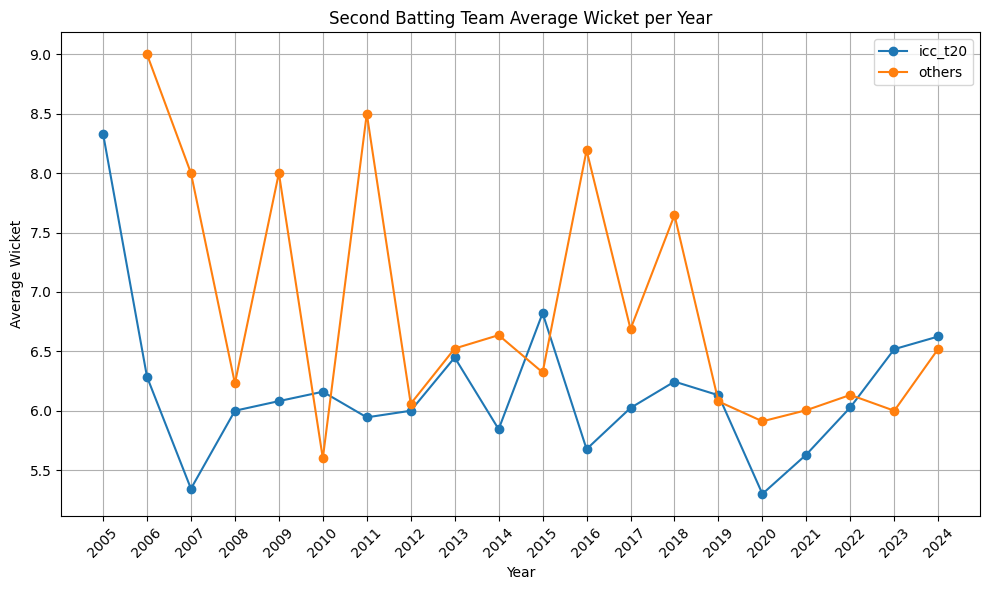

In [9]:
import matplotlib.pyplot as plt

# Filter data for icc_t20 and others
icc_t20_data = combined_df[combined_df['type'] == 'icc_t20']
others_data = combined_df[combined_df['type'] == 'others']

# Group data by year and calculate average wicket
icc_t20_avg_runs = icc_t20_data.groupby(icc_t20_data['date'].dt.year)['wicket'].mean()
others_avg_runs = others_data.groupby(others_data['date'].dt.year)['wicket'].mean()

# Plotting
plt.figure(figsize=(10, 6))

# Line plot for icc_t20
plt.plot(icc_t20_avg_runs.index, icc_t20_avg_runs.values, marker='o', label='icc_t20')

# Line plot for others
plt.plot(others_avg_runs.index, others_avg_runs.values, marker='o', label='others')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Average Wicket')
plt.title('Second Batting Team Average Wicket per Year')
plt.legend()

# Customize x-axis to show years from 2005 to 2024
plt.xticks(range(2005, 2025, 1), rotation=45)

# Show grid
plt.grid(True)

# Save the plot
plt.tight_layout()
plt.savefig('Second Batting Team Average Wicket per Year.png')
plt.show()